# Libraries

In [5]:
# Libraries
import os
import os.path as osp
import copy
import json
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob

import mmcv

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

from mmcv import Config 
from mmdet.datasets import build_dataset 
from mmdet.models import build_detector 
from mmdet.apis import train_detector 
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor)

from mmdet.apis import set_random_seed

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

# Setting

In [6]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'mask_rcnn': {
        'config_file': 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
    },
    # dir need to revise
    'detectors': {
        'config_file': 'configs/detectors/detectors_htc_r50_1x_coco.py',
    },
    'yolact': {
        'config_file': 'configs/yolact/yolact_r101_1x8_coco.py'
    }
}

In [7]:
# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'mask_rcnn'  # 'cascade_mask_rcnn_r50_fpn_1x'

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

# Modify configuration

In [8]:
config_fname = os.path.join(config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

In [9]:
dir = open("./data/train.json", "r", encoding="utf-8")
coco = json.load(dir)
print(coco["categories"])
classes_names = [category["name"] for category in coco["categories"]]
print(classes_names)

[{'id': 1, 'name': 'pet'}, {'id': 2, 'name': 'ps'}, {'id': 3, 'name': 'pp'}, {'id': 4, 'name': 'pe'}]
['pet', 'ps', 'pp', 'pe']


In [10]:
# saved config checking
cfg = Config.fromfile(config_fname) 

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_wei

In [11]:
# config
cfg = Config.fromfile(config_fname) 

cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)
cfg.lr_config = dict(policy='step', warmup='linear', warmup_iters=500, warmup_ratio=0.001, step=[8, 11])
cfg.total_epochs = 12
cfg.runner.max_epochs = 12

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.model.roi_head.mask_head.num_classes = 4

# Modify dataset type and path
dataset_type = 'CocoDataset'
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
data_root = '/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/'
classes = ('pet', 'ps', 'pp', 'pe')

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1024, 1024), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),])]

cfg.data = dict(samples_per_gpu=8,workers_per_gpu=1,
    train=dict(
        type=dataset_type,
        classes = classes,
        ann_file=data_root + 'train.json',
        img_prefix=data_root + 'train',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline))
cfg.evaluation = dict(metric=['bbox', 'segm'])

cfg.checkpoint_config = dict(interval=1)
cfg.work_dir = './log'
cfg.log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])  # dict(type='TensorboardLoggerHook')

# yapf:enable
cfg.dist_params = dict(backend='nccl')
cfg.log_level = 'INFO'
cfg.load_from = 'checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth'
cfg.resume_from = None
cfg.workflow = [('train', 1)]

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_wei

In [ ]:
import gc
gc.collect()

# GPU 캐시 데이터 삭제 
import torch
torch.cuda.empty_cache() 

In [22]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


2021-12-09 10:22:49,305 - mmdet - INFO - load checkpoint from local path: checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
2021-12-09 10:22:49,397 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256,

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2021-12-09 10:23:33,223 - mmdet - INFO - Epoch [1][50/499]	lr: 9.890e-04, eta: 1:26:24, time: 0.873, data_time: 0.092, memory: 13324, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0056, loss_cls: 0.6558, acc: 74.2632, loss_bbox: 0.4804, loss_mask: 0.3754, loss: 1.5198
2021-12-09 10:24:12,335 - mmdet - INFO - Epoch [1][100/499]	lr: 1.988e-03, eta: 1:21:14, time: 0.782, data_time: 0.036, memory: 13324, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0061, loss_cls: 0.1704, acc: 93.9443, loss_bbox: 0.2797, loss_mask: 0.0554, loss: 0.5123
2021-12-09 10:24:49,889 - mmdet - INFO - Epoch [1][150/499]	lr: 2.987e-03, eta: 1:18:03, time: 0.751, data_time: 0.029, memory: 13324, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0052, loss_cls: 0.0839, acc: 97.1597, loss_bbox: 0.1139, loss_mask: 0.0605, loss: 0.2639
2021-12-09 10:25:28,181 - mmdet - INFO - Epoch [1][200/499]	lr: 3.986e-03, eta: 1:16:30, time: 0.766, data_time: 0.032, memory: 13324, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0045, loss_cls: 0.0613, acc: 97.9829, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 11.7 task/s, elapsed: 34s, ETA:     0s

2021-12-09 10:29:58,534 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...


2021-12-09 10:29:58,820 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.949
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.891
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.920
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.920
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.920
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.957
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.05s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 10:29:59,379 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.05s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 10:30:41,985 - mmdet - INFO - Epoch [2][50/499]	lr: 1.000e-02, eta: 1:05:35, time: 0.848, data_time: 0.088, memory: 13324, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0042, loss_cls: 0.0450, acc: 98.6035, loss_bbox: 0.0695, loss_mask: 0.0361, loss: 0.1552
2021-12-09 10:31:22,956 - mmdet - INFO - Epoch [2][100/499]	lr: 1.000e-02, eta: 1:05:42, time: 0.819, data_time: 0.036, memory: 13324, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0040, loss_cls: 0.0347, acc: 98.8232, loss_bbox: 0.0696, loss_mask: 0.0270, loss: 0.1356
2021-12-09 10:32:04,320 - mmdet - INFO - Epoch [2][150/499]	lr: 1.000e-02, eta: 1:05:45, time: 0.827, data_time: 0.037, memory: 13324, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 11.2 task/s, elapsed: 36s, ETA:     0s

2021-12-09 10:37:32,622 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 10:37:32,917 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.995
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.995
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.934
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.954
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.954
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.954
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.05s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 10:37:33,267 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.05s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 10:38:16,575 - mmdet - INFO - Epoch [3][50/499]	lr: 1.000e-02, eta: 1:00:52, time: 0.863, data_time: 0.089, memory: 13325, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0032, loss_cls: 0.0297, acc: 99.0156, loss_bbox: 0.0448, loss_mask: 0.0245, loss: 0.1024
2021-12-09 10:38:58,255 - mmdet - INFO - Epoch [3][100/499]	lr: 1.000e-02, eta: 1:00:36, time: 0.833, data_time: 0.038, memory: 13325, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0034, loss_cls: 0.0306, acc: 98.9839, loss_bbox: 0.0525, loss_mask: 0.0320, loss: 0.1188
2021-12-09 10:39:41,014 - mmdet - INFO - Epoch [3][150/499]	lr: 1.000e-02, eta: 1:00:22, time: 0.855, data_time: 0.038, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.0 task/s, elapsed: 31s, ETA:     0s

2021-12-09 10:45:00,526 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...


2021-12-09 10:45:00,784 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.920
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.942
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.942
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.942
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.957
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.05s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 10:45:01,238 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 10:45:47,348 - mmdet - INFO - Epoch [4][50/499]	lr: 1.000e-02, eta: 0:55:12, time: 0.918, data_time: 0.093, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0029, loss_cls: 0.0253, acc: 99.1895, loss_bbox: 0.0460, loss_mask: 0.0433, loss: 0.1177
2021-12-09 10:46:29,940 - mmdet - INFO - Epoch [4][100/499]	lr: 1.000e-02, eta: 0:54:50, time: 0.852, data_time: 0.040, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0032, loss_cls: 0.0247, acc: 99.1382, loss_bbox: 0.0399, loss_mask: 0.0390, loss: 0.1070
2021-12-09 10:47:12,376 - mmdet - INFO - Epoch [4][150/499]	lr: 1.000e-02, eta: 0:54:25, time: 0.849, data_time: 0.041, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.1 task/s, elapsed: 31s, ETA:     0s

2021-12-09 10:52:32,152 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 10:52:32,400 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.969
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.936
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.955
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.955
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.955
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 10:52:32,716 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 10:53:15,568 - mmdet - INFO - Epoch [5][50/499]	lr: 1.000e-02, eta: 0:49:09, time: 0.853, data_time: 0.090, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0029, loss_cls: 0.0231, acc: 99.2847, loss_bbox: 0.0412, loss_mask: 0.0261, loss: 0.0935
2021-12-09 10:53:56,218 - mmdet - INFO - Epoch [5][100/499]	lr: 1.000e-02, eta: 0:48:38, time: 0.813, data_time: 0.041, memory: 13325, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0029, loss_cls: 0.0250, acc: 99.2690, loss_bbox: 0.0376, loss_mask: 0.0371, loss: 0.1029
2021-12-09 10:54:37,665 - mmdet - INFO - Epoch [5][150/499]	lr: 1.000e-02, eta: 0:48:07, time: 0.829, data_time: 0.041, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 12.7 task/s, elapsed: 31s, ETA:     0s

2021-12-09 10:59:56,808 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 10:59:57,061 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.942
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.959
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.959
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.959
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 10:59:57,383 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:00:43,662 - mmdet - INFO - Epoch [6][50/499]	lr: 1.000e-02, eta: 0:42:58, time: 0.922, data_time: 0.091, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0027, loss_cls: 0.0267, acc: 99.1719, loss_bbox: 0.0371, loss_mask: 0.0344, loss: 0.1012
2021-12-09 11:01:25,697 - mmdet - INFO - Epoch [6][100/499]	lr: 1.000e-02, eta: 0:42:26, time: 0.841, data_time: 0.038, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0026, loss_cls: 0.0199, acc: 99.3643, loss_bbox: 0.0373, loss_mask: 0.0281, loss: 0.0881
2021-12-09 11:02:06,740 - mmdet - INFO - Epoch [6][150/499]	lr: 1.000e-02, eta: 0:41:53, time: 0.821, data_time: 0.038, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.0 task/s, elapsed: 31s, ETA:     0s

2021-12-09 11:07:26,463 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 11:07:26,697 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.968
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.981
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.981
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.981
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:07:27,001 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:08:11,461 - mmdet - INFO - Epoch [7][50/499]	lr: 1.000e-02, eta: 0:36:46, time: 0.886, data_time: 0.093, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0023, loss_cls: 0.0187, acc: 99.4087, loss_bbox: 0.0336, loss_mask: 0.0339, loss: 0.0887
2021-12-09 11:08:52,464 - mmdet - INFO - Epoch [7][100/499]	lr: 1.000e-02, eta: 0:36:11, time: 0.820, data_time: 0.041, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0026, loss_cls: 0.0197, acc: 99.3369, loss_bbox: 0.0390, loss_mask: 0.0258, loss: 0.0873
2021-12-09 11:09:33,793 - mmdet - INFO - Epoch [7][150/499]	lr: 1.000e-02, eta: 0:35:37, time: 0.827, data_time: 0.042, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 12.3 task/s, elapsed: 33s, ETA:     0s

2021-12-09 11:14:56,815 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 11:14:57,086 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.936
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.957
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.972
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.972
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.972
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:14:57,456 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:15:41,439 - mmdet - INFO - Epoch [8][50/499]	lr: 1.000e-02, eta: 0:30:33, time: 0.876, data_time: 0.097, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0025, loss_cls: 0.0301, acc: 99.1519, loss_bbox: 0.0312, loss_mask: 0.0378, loss: 0.1018
2021-12-09 11:16:22,499 - mmdet - INFO - Epoch [8][100/499]	lr: 1.000e-02, eta: 0:29:58, time: 0.821, data_time: 0.044, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0028, loss_cls: 0.0161, acc: 99.4585, loss_bbox: 0.0344, loss_mask: 0.0378, loss: 0.0914
2021-12-09 11:17:04,123 - mmdet - INFO - Epoch [8][150/499]	lr: 1.000e-02, eta: 0:29:23, time: 0.832, data_time: 0.043, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.3 task/s, elapsed: 30s, ETA:     0s

2021-12-09 11:22:18,947 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 11:22:19,184 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.979
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:22:19,481 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:23:01,800 - mmdet - INFO - Epoch [9][50/499]	lr: 1.000e-03, eta: 0:24:17, time: 0.843, data_time: 0.092, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0019, loss_cls: 0.0171, acc: 99.4805, loss_bbox: 0.0245, loss_mask: 0.0226, loss: 0.0663
2021-12-09 11:23:42,173 - mmdet - INFO - Epoch [9][100/499]	lr: 1.000e-03, eta: 0:23:40, time: 0.807, data_time: 0.038, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0016, loss_cls: 0.0197, acc: 99.4639, loss_bbox: 0.0225, loss_mask: 0.0229, loss: 0.0669
2021-12-09 11:24:22,616 - mmdet - INFO - Epoch [9][150/499]	lr: 1.000e-03, eta: 0:23:04, time: 0.809, data_time: 0.038, memory: 13325, loss_rpn_cls: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.9 task/s, elapsed: 29s, ETA:     0s

2021-12-09 11:29:13,555 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 11:29:13,788 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.989
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:29:14,204 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:29:53,917 - mmdet - INFO - Epoch [10][50/499]	lr: 1.000e-03, eta: 0:17:54, time: 0.791, data_time: 0.088, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0016, loss_cls: 0.0131, acc: 99.6025, loss_bbox: 0.0227, loss_mask: 0.0250, loss: 0.0627
2021-12-09 11:30:30,910 - mmdet - INFO - Epoch [10][100/499]	lr: 1.000e-03, eta: 0:17:17, time: 0.740, data_time: 0.035, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0016, loss_cls: 0.0170, acc: 99.4971, loss_bbox: 0.0227, loss_mask: 0.0356, loss: 0.0771
2021-12-09 11:31:07,889 - mmdet - INFO - Epoch [10][150/499]	lr: 1.000e-03, eta: 0:16:40, time: 0.740, data_time: 0.034, memory: 13325, loss_rpn_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.0 task/s, elapsed: 31s, ETA:     0s

2021-12-09 11:36:13,532 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...


2021-12-09 11:36:13,771 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.987
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:36:14,077 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:36:57,063 - mmdet - INFO - Epoch [11][50/499]	lr: 1.000e-03, eta: 0:11:40, time: 0.856, data_time: 0.093, memory: 13325, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0016, loss_cls: 0.0136, acc: 99.5640, loss_bbox: 0.0217, loss_mask: 0.0213, loss: 0.0583
2021-12-09 11:37:37,796 - mmdet - INFO - Epoch [11][100/499]	lr: 1.000e-03, eta: 0:11:04, time: 0.815, data_time: 0.039, memory: 13325, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0016, loss_cls: 0.0179, acc: 99.4736, loss_bbox: 0.0234, loss_mask: 0.0294, loss: 0.0724
2021-12-09 11:38:18,027 - mmdet - INFO - Epoch [11][150/499]	lr: 1.000e-03, eta: 0:10:27, time: 0.805, data_time: 0.042, memory: 13325, loss_rpn_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 12.6 task/s, elapsed: 32s, ETA:     0s

2021-12-09 11:43:37,477 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-09 11:43:37,729 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.985
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.990
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.990
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.990
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:43:38,039 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-09 11:44:24,059 - mmdet - INFO - Epoch [12][50/499]	lr: 1.000e-04, eta: 0:05:31, time: 0.916, data_time: 0.096, memory: 13325, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0015, loss_cls: 0.0197, acc: 99.4497, loss_bbox: 0.0210, loss_mask: 0.0286, loss: 0.0709
2021-12-09 11:45:05,842 - mmdet - INFO - Epoch [12][100/499]	lr: 1.000e-04, eta: 0:04:55, time: 0.836, data_time: 0.043, memory: 13325, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0016, loss_cls: 0.0149, acc: 99.5610, loss_bbox: 0.0222, loss_mask: 0.0316, loss: 0.0704
2021-12-09 11:45:46,789 - mmdet - INFO - Epoch [12][150/499]	lr: 1.000e-04, eta: 0:04:18, time: 0.819, data_time: 0.042, memory: 13325, loss_rpn_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 13.2 task/s, elapsed: 30s, ETA:     0s

2021-12-09 11:51:02,977 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


2021-12-09 11:51:03,212 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.987
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.04s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-09 11:51:03,640 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.04s).


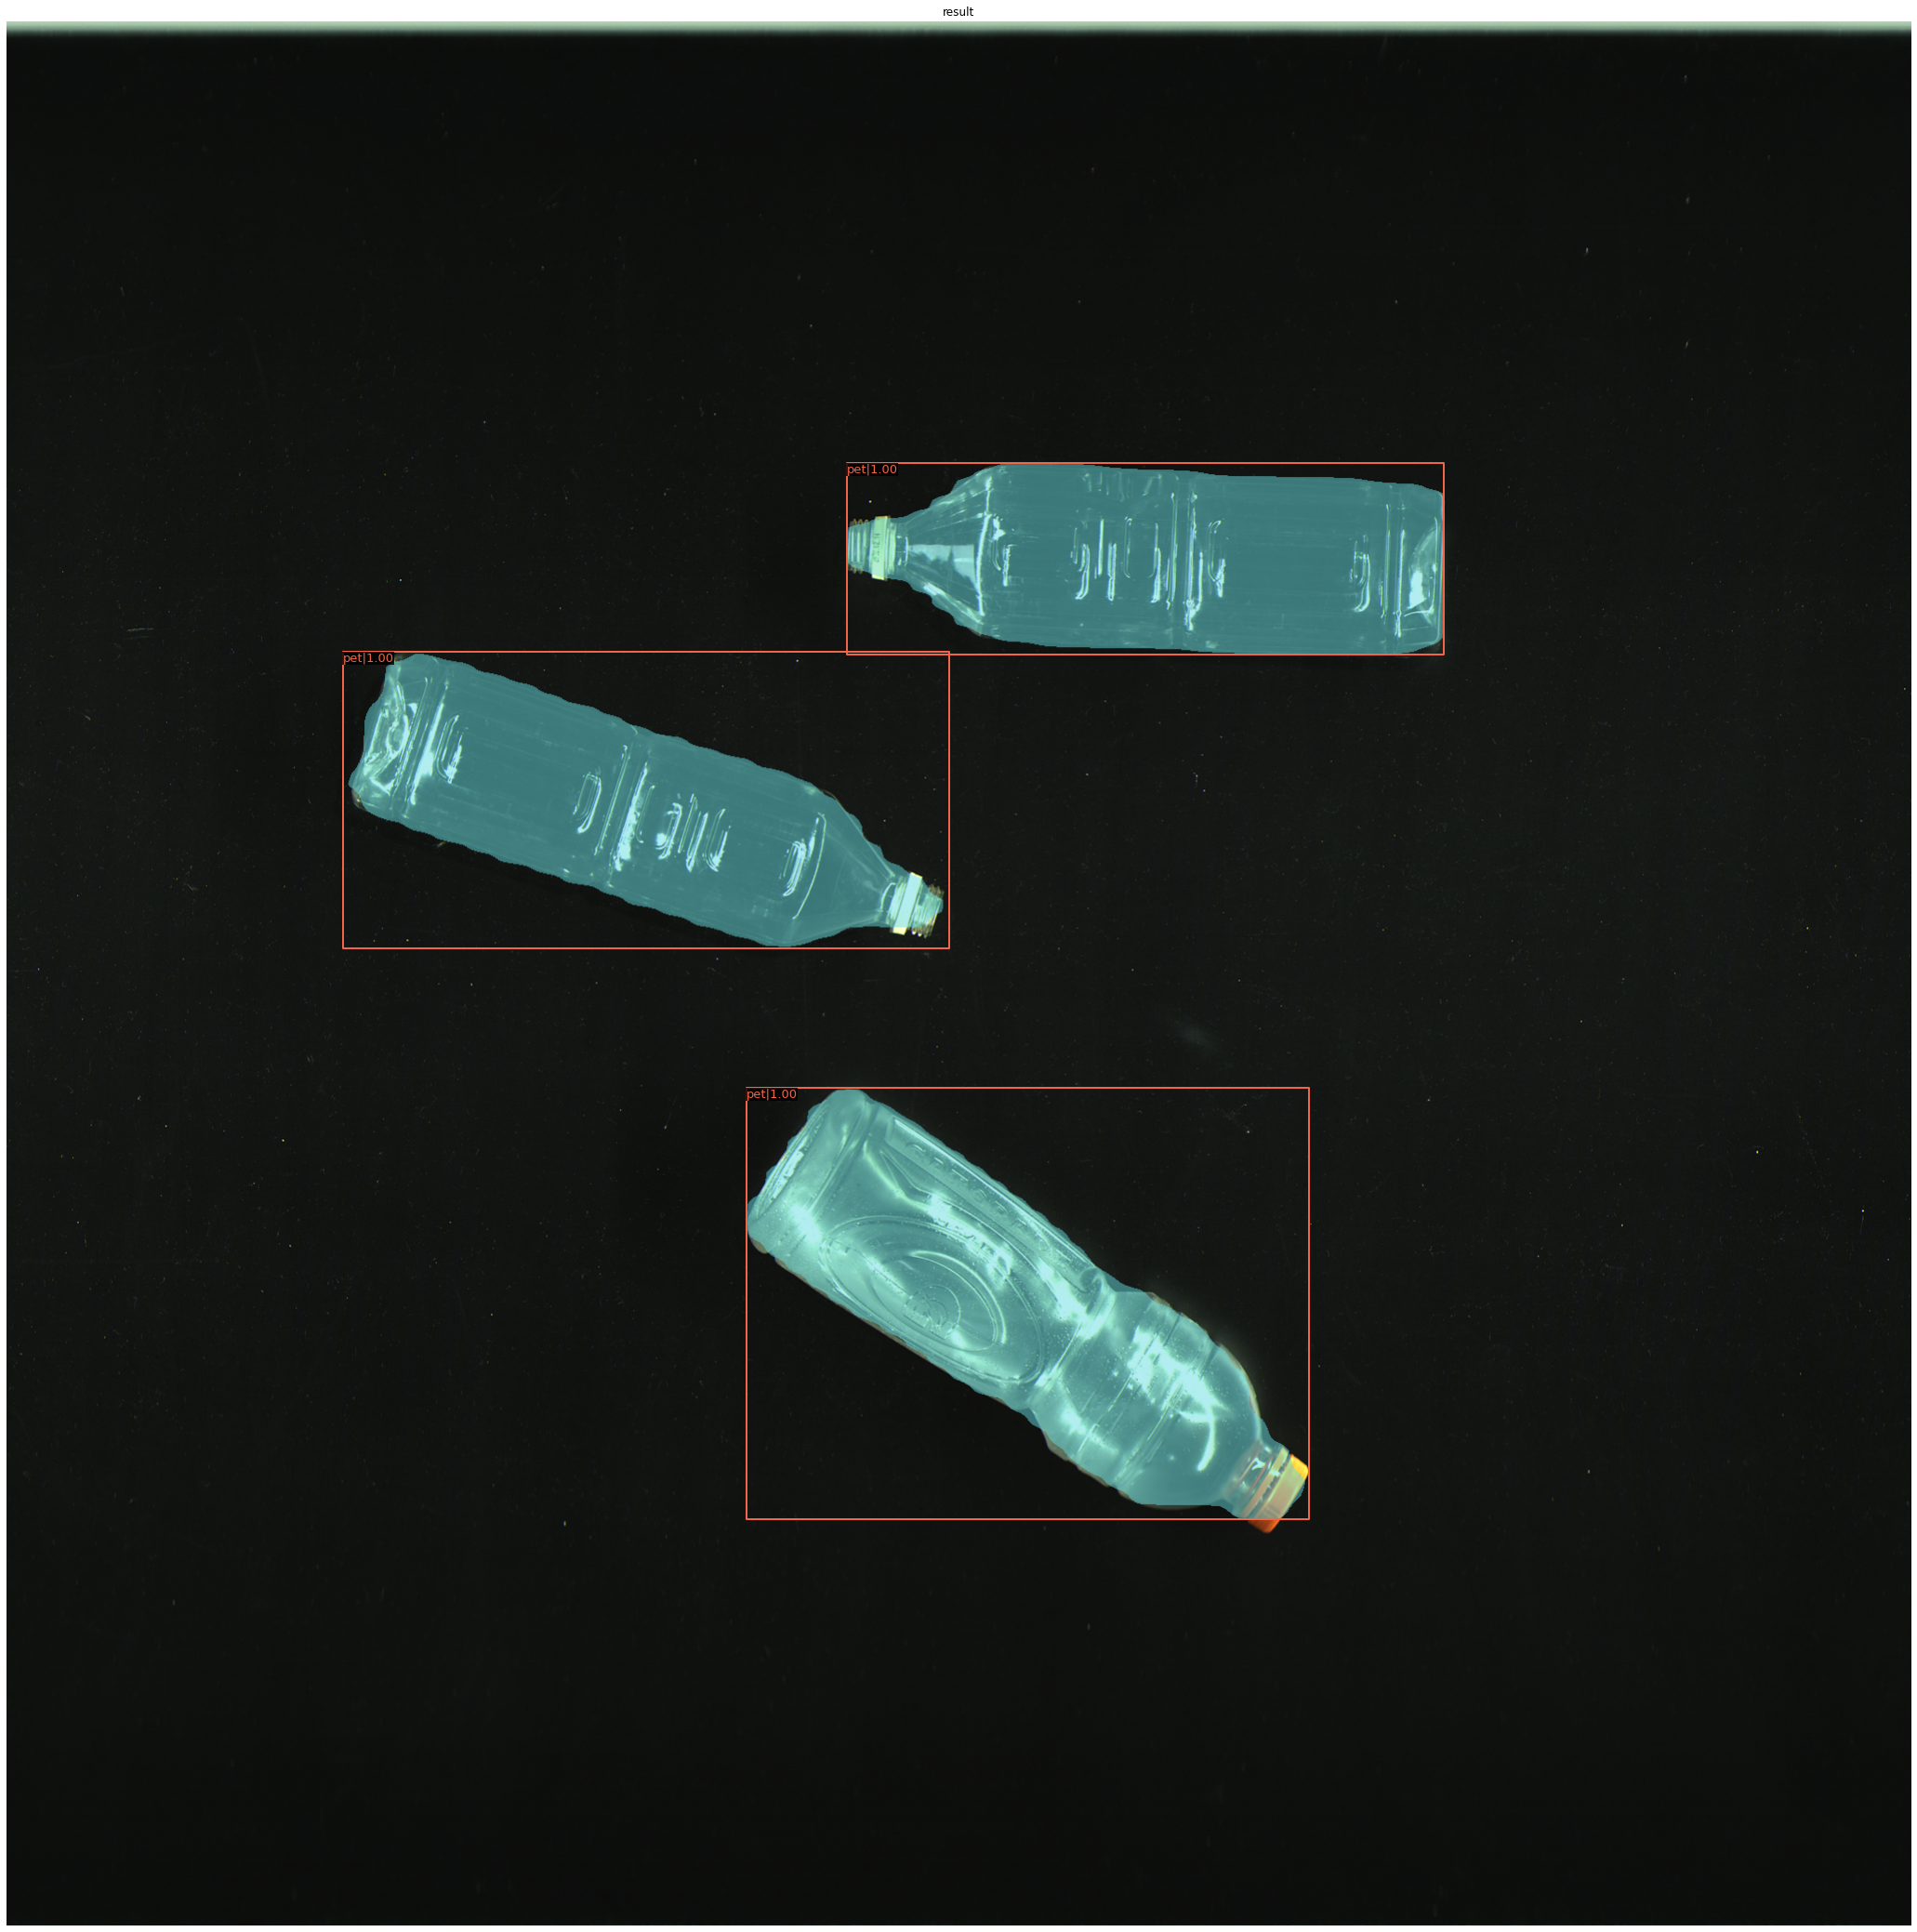

In [31]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = mmcv.imread('/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/test/PET_002_1241.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)